# Problem Statement





ERC is a task that aims at predicting emotion of each utterance in a conversation. The following is an excerpt of a conversation with each utterance tagged with corresponding emotion and sentiment label.

![alt text](example.jpg "Title")


# Hierarchical Transformer Network for Utterance-Level Emotion Recognition
This is the Pytorch implementation Utterance-level Emotion Recognition [paper](https://arxiv.org/ftp/arxiv/papers/2002/2002.07551.pdf)

Overview
Though predicting the emotion of a single utterance or sentence, i.e. emotion detection, is a well discussed subject in natural language understanding literature, EmoContext has several novel challenges. In this paper, we address four challenges in utterance-level emotion recognition in dialogue systems:

- Emotion depend on the context of previous utterances in the dialogue

- long-range contextual information is hard to be effectively captured;

- Datasets are quite small.

- the class distribution of training data is significantly different from that of the test data. Consequently, a model trained on the training data might not perform well on the test data.

- We propose a hierarchical transformer framework with a lower-level transformer to model the word-level inputs and an upper-level transformer to capture the contexts of utterance-level embeddings.

# Dataset
Dataset includes the training data set consisting of 30160 dialogues, and two evaluation data sets, Test1 and Test2, containing
2755 and 5509 dialogues respectively. The Training dataset is a .txt file containing 5 columns :

 - ID - Contains a unique number to identify each training sample
 - Turn 1 - Contains the first turn in the three turn conversation, written by User 1
 - Turn 2 - Contains the second turn, which is a reply to the first turn in conversation and is written by User 2
 - Turn 3 - Contains the third turn, which is a reply to the second turn in the conversation, which is written by User 1
 - Label - Contains the human judged label of Emotion of Turn 3 based on the conversation for the given training sample. It is always one of the four values - 'happy', 'sad, 'angry' and 'others'
 
Training data consists of about 5k samples each from 'angry', 'sad', 'happy' class, and 15k samples from 'others' class, whereas, both Dev and Test sets have a real life distribution, which is about 4% each of 'angry', 'sad', 'happy' class and the rest is 'others' class. 
    
Dataset stattistics:


| Statistics | Train | Dev | Test | 
| :-| :- | :- | :- | 
| # of Dialogues | 30160 | 2755 |5509 | 
| # of Utterances | 90480 | 8265 |16527 | 
| Min number of Utterances per dialogue| 3 | 3 |3 | 
| Max number of Utterances per dialogue| 3 | 3 |3 | 
| Average number of Utterances per dialogue| 3 | 3 |3 | 
| Min Utterance length | 1 | 1 |1 | 
| Max Utterance length | 145 | 72 |113 | 
| Average Utterance length | 5.45 | 5.22 |5.21 | 


    
    

In [1]:
import torch
import os
import random
import pandas as pd
import functools
import time
import math
import argparse
import json


from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from ipywidgets import interact
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from transformers import DistilBertModel, DistilBertForSequenceClassification, DistilBertConfig, DistilBertTokenizer

from collections import defaultdict

import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from sklearn.preprocessing import OneHotEncoder

In [2]:
def get_args():
    """
        returns the Parser args
    """
    root_dir = os.getcwd()  
    parser = argparse.ArgumentParser()
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--projection_size', type=int, default=100)
    parser.add_argument('--n_layers', type=int, default=1)
    parser.add_argument('--dropout', type=float, default=0.1)
    parser.add_argument('--lr', type=float, default=2e-5)
    parser.add_argument('--bert_lr', type=float, default=1e-5)
    parser.add_argument('--layerwise_decay', default=0.95, type=float,  
                    help='layerwise decay factor for the learning rate of the pretrained DistilBert')
    
    #parser.add_argument('--train_file', default=os.path.join(root_dir, 'data/clean_train.txt'), type=str)
    #parser.add_argument('--val_file', default=os.path.join(root_dir, 'data/clean_val.txt'), type=str)
    #parser.add_argument('--test_file', default=os.path.join(root_dir, 'data/clean_test.txt'), type=str)
    parser.add_argument('--weight_decay', type=float, default=1e-5)
    parser.add_argument('--max_grad_norm', type=float, default=1.0)
    parser.add_argument('--epochs', type=int, default=2,
                        help='number of total epochs to run')
    parser.add_argument('--max_seq_len', type=int, default=35   )
   
    parser.add_argument('--alpha', type=float, default=0.95)
    parser.add_argument('--seed', type=int, default=123,
                       help='seed for initializing training')
    parser.add_argument('--device', type=int, default=0)

    parser.add_argument('--evaluate', action='store_true')
    parser.add_argument('--gpu', type=str, default='0',		# Spcify the GPU for training
                       help='gpu: default 0')
    parser.add_argument('--emoset', type=str, default = 'emorynlp',
                        help = 'Emotion Training Set Name')
    parser.add_argument('--speaker_embedding',  action="store_true",
                        help = 'Enable Speaker Embedding')
    args = parser.parse_args(args=['--speaker_embedding', '--emoset', 'semeval'])
    return args

In [3]:
args = get_args()
print(args, '\n')
args.emoset = args.emoset.lower()
assert args.emoset  in ['emorynlp', 'emotionpush', 'friends','semeval']
if args.emoset == 'semeval':
    args.speaker_embedding = False 

if not args.emoset == 'semeval':
    args.batch_size = 1

Namespace(alpha=0.95, batch_size=32, bert_lr=1e-05, device=0, dropout=0.1, emoset='semeval', epochs=2, evaluate=False, gpu='0', layerwise_decay=0.95, lr=2e-05, max_grad_norm=1.0, max_seq_len=35, n_layers=1, projection_size=100, seed=123, speaker_embedding=True, weight_decay=1e-05) 



### Set the seed for deterministic behavior

In [4]:
seed = args.seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
seed_everything(42, workers=True)

Global seed set to 42


42

### Set cuda device

In [5]:
device = torch.device("cuda:{}".format(int(args.gpu)) if torch.cuda.is_available() else "cpu")
args.device = device
print('Args.device = {}'.format(args.device))

Args.device = cuda:0


In [6]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Read Dataset CSV Files

In [7]:
'''
  Create Pandas Dataframe from EmoryNLP Dataset Json Files
  Parameters
    ----------
    Data : Json File 
        Json File containing Train/Val/Test Data
    Column_list : Python List
        Column list for the created dataframe    
    Returns
    -------
   df: Pandas Dataframe
'''

def create_df_emorynlp(data, column_list):
    df = pd.DataFrame(columns = column_list)
    dialogue_idx = 0
    episode_idx = 0
    for episode in data['episodes']:
        scenes = episode['scenes']
        for i in range(len(scenes)):
            for j in range(len(scenes[i]['utterances'])):
                df2 = pd.DataFrame([[dialogue_idx, scenes[i]['utterances'][j]['transcript'] , scenes[i]['utterances'][j]['speakers'][0], len(scenes[i]['utterances'][j]['transcript'].split()), scenes[i]['utterances'][j]['emotion'].lower() ]], columns = column_list)
                df = df.append(df2, ignore_index=True)
            dialogue_idx += 1
        episode_idx = episode_idx+1
          
    return df

'''
  Create Pandas Dataframe from Friends/EmotionPush Dataset Json Files
   Parameters
    ----------
    Data : Json File 
        Json File containing Train/Val/Test Data
    Column_list : Python List
        Column list for the created dataframe    
    Returns
    -------
   df: Pandas Dataframe
'''
def create_df_friends(data, column_list):
    df = pd.DataFrame(columns = column_list)
    dialogue_idx = 0
    for dialog in data:
        for utter in dialog:
            df2 = pd.DataFrame([[dialogue_idx, utter['utterance'], utter['speaker'], len(utter['utterance'].split()), utter['emotion'].lower() ]], columns = column_list)
            df = df.append(df2, ignore_index=True)
        dialogue_idx += 1
         
    return df

def create_df(data, emoset):
    column_list = list(('dialogue_id', 'utterance', 'speaker','utterance_len', 'label'))
    if emoset == 'emorynlp':
        df=  create_df_emorynlp(data, column_list)
    else:
        df = create_df_friends(data, column_list)
    return df

'''
  Create Pandas Dataframe for Train, Validation and Test Data from Dataset Json Files
  
'''
def load_df(args):
    
    if args.emoset == 'emorynlp':
        print('Creating Training/Val/Test Dataframesfor EmoryNLP Dataset')
        train_path = '../data/EmoryNLP/json/emotion-detection-trn.json'
        val_path = '../data/EmoryNLP/json/emotion-detection-dev.json'
        test_path = '../data/EmoryNLP/json/emotion-detection-tst.json'
    elif  args.emoset == 'emotionpush':
        print('Creating Training/Val/Test Dataframesfor EmotionPush Dataset')
        train_path = '../data/Emotionpush/emotionpush.train.json'
        val_path =   '../data/Emotionpush/emotionpush.dev.json'
        test_path =  '../data/Emotionpush/emotionpush.test.json'
    elif  args.emoset == 'friends': 
        print('Creating Training/Val/Test Dataframesfor Friends Dataset')
        train_path = '../data/Friends/friends.train.json'
        val_path = '../data/Friends/friends.dev.json'
        test_path = '../data/Friends/friends.test.json'
    else:
        print('Creating Training/Val/Test Dataframesfor Semeval Dataset')
        train_path = '../data/clean_train.txt'
        val_path = '../data/clean_val.txt'
        test_path = '../data/clean_test.txt'

    if not args.emoset == 'semeval':
        with open(train_path, encoding='utf-8') as data_file:
            train_json = json.loads(data_file.read())
        
        with open(val_path, encoding='utf-8') as data_file:
            val_json = json.loads(data_file.read())
        
        with open(test_path, encoding='utf-8') as data_file:
            test_json = json.loads(data_file.read())
        
        df_train = create_df(train_json, args.emoset)
        df_val = create_df(val_json,  args.emoset)       
        df_test = create_df(test_json,  args.emoset) 
    else:
        df_train = pd.read_csv(train_path, delimiter='\t', index_col='id')
        df_val =  pd.read_csv(val_path, delimiter='\t', index_col='id')    
        df_test = pd.read_csv(test_path, delimiter='\t', index_col='id')
                
    return (df_train, df_val, df_test)

In [8]:
(df_train, df_val, df_test)  = load_df(args)   

Creating Training/Val/Test Dataframesfor Semeval Dataset


In [9]:
df_train

,turn1,turn2,turn3,label
id,,,,
0,do not worry i am girl,hmm how do i know if you are,what ' s ur name ?,others
1,when did i ?,saw many times i think shame,no . i never saw you,angry
2,by,by google chrome,where you live,others
3,u r ridiculous,i might be ridiculous but i am telling the tru...,u little disgusting whore,angry
4,just for time pass,wt do u do 4 a living then,maybe,others
...,...,...,...,...
30155,i do not work,i could take your shift,i am a student,others
30156,i am not getting you repeated loudly crying face,why are you crying confused,because you are not making any sense,sad
30157,haha,"no , seriously . what is up with that o - o",had your breakfast ?,others


#  Number of Dialogues in Training and Evaluation Sets

In [10]:
if not args.emoset == 'semeval':
    len(df_train['dialogue_id'].unique()), len(df_val['dialogue_id'].unique()), len(df_test['dialogue_id'].unique())
else:
    print('Number of dialogues in Train/Val/Test = {}/{}/{}'.format(df_train.shape[0], df_val.shape[0], df_test.shape[0]))

Number of dialogues in Train/Val/Test = 30160/2755/5509


#  Number of utterances in Training and Evaluation Sets

In [11]:
df_train.shape[0], df_val.shape[0], df_test.shape[0]

(30160, 2755, 5509)

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30160 entries, 0 to 30159
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   turn1   30160 non-null  object
 1   turn2   30160 non-null  object
 2   turn3   30160 non-null  object
 3   label   30160 non-null  object
dtypes: object(4)
memory usage: 1.2+ MB


In [13]:
df_train['label'].value_counts(), df_val['label'].value_counts(), df_test['label'].value_counts()

(others    14948
 angry      5506
 sad        5463
 happy      4243
 Name: label, dtype: int64,
 others    2338
 angry      150
 happy      142
 sad        125
 Name: label, dtype: int64,
 others    4677
 angry      298
 happy      284
 sad        250
 Name: label, dtype: int64)

#  Comparison of class distribution in Training vs Evaluation data sets

| Emotion | Happy | Sad | Angry | others | # |
| :-: | :-: | :-: | :-: | :-: | :-: |
| Train | 4243 | 5463 |5506 | 14948| 30160|
| Dev | 142 | 125 |150 | 2338| 2755|
| Test | 284 | 250 |298 | 4677| 5509|

In [14]:
data = [df_train['label'], df_val['label'], df_test['label']]
columns=list(('Training', 'Validation', 'Test'))
df_labels = pd.concat(data, axis=1, keys=columns)

In [15]:
set(df_train.label)

{'angry', 'happy', 'others', 'sad'}

[Text(0, 0, 'happy'),
 Text(1, 0, 'sad'),
 Text(2, 0, 'angry'),
 Text(3, 0, 'others')]

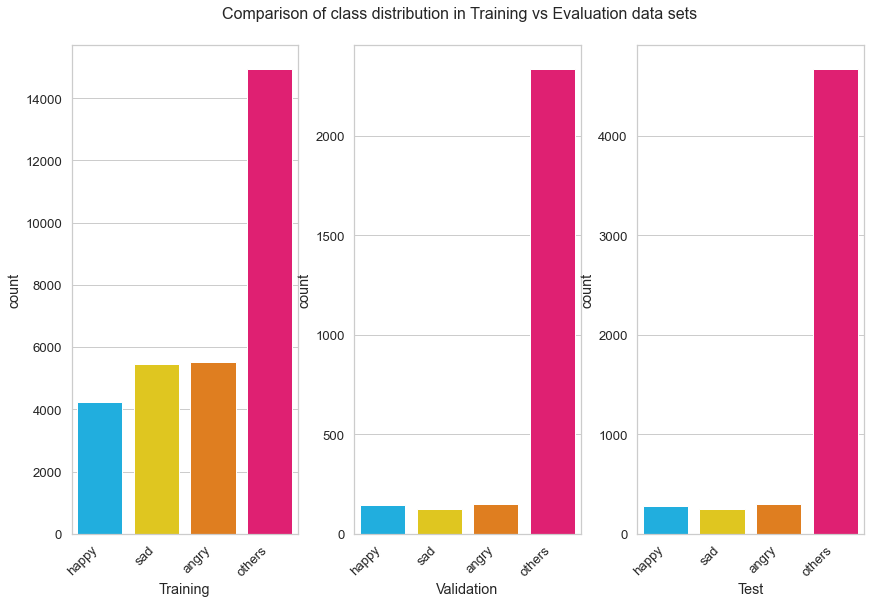

In [43]:
fig, ax =plt.subplots(1,3)
fig.suptitle('Comparison of class distribution in Training vs Evaluation data sets', fontsize=16)
fig.tight_layout()
emotion_list = ['happy', 'sad', 'angry', 'others']
chart = sns.countplot(x="Training",   data=df_labels, order = emotion_list, ax=ax[0])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart = sns.countplot(x="Validation", data=df_labels, order = emotion_list, ax=ax[1])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart = sns.countplot(x="Test",       data=df_labels, order = emotion_list, ax=ax[2])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

# Scale of class imbalance is different in Training and Evaluation data sets
| Emotion | Happy | Sad | Angry | others |
| :-: | :-: | :-: | :-: | :-: |
| Train | 14% | 18% |18% | 50%|
| Dev | 5% | 4.5% |5.5% | 85%|
| Test | 5% | 4.5% |5.5% | 85%|

Training data consists of about 5k samples each from 'angry', 'sad', 'happy' class, and 15k samples from 'others' class, whereas, both Dev and Test sets have a real life distribution, which is about 4% each of 'angry', 'sad', 'happy' class and the rest is 'others' class.

In [17]:
train = pd.Series(['Training'] , ['name'])
train = train.append(df_labels['Training'].value_counts().div(df_labels['Training'].value_counts().sum()))
val = pd.Series(['Validation'] , ['name'])
val = val.append(df_labels['Validation'].value_counts().div(df_labels['Validation'].value_counts().sum()))
test = pd.Series(['Test'] , ['name'])
test = test.append(df_labels['Test'].value_counts().div(df_labels['Test'].value_counts().sum()))

df_stacked = pd.DataFrame(columns = emotion_list)

df_stacked = df_stacked.append(train,ignore_index=True)
df_stacked = df_stacked.append(val,ignore_index=True)
df_stacked = df_stacked.append(test,ignore_index=True)

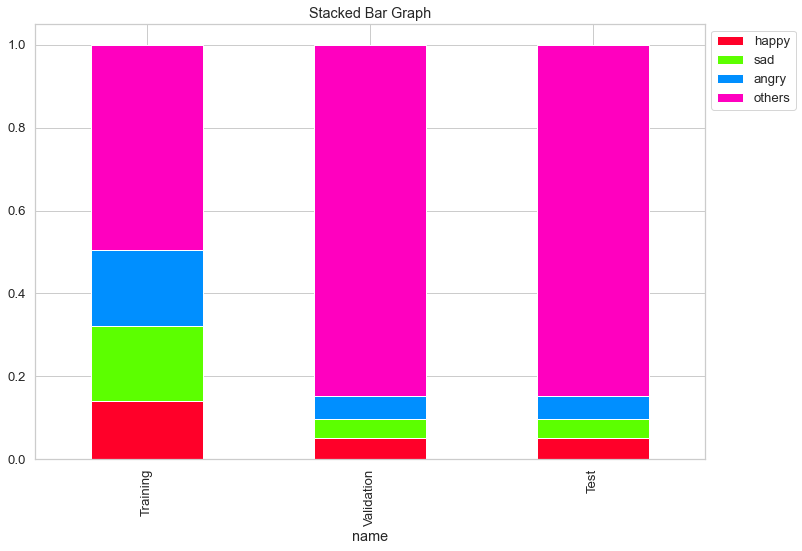

In [18]:
# plot a Stacked Bar Chart using matplotlib
df_stacked.plot(
    x = 'name',
    kind = 'bar',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = False, 
    colormap='gist_rainbow'
   ).legend(bbox_to_anchor=(1, 1))

# Distribution of number of utterances per dialogue in Train and Evaluation Sets
- Number of utterances per dialogure is fixed at 3 for Training, Validation and Test set 


# Distribution of Utterance Length in Train and Evaluation Sets
- Length of utterances follows almost similar distribution in train and evaluation datasets
- 99.9 percentile for the Training/Validation/Test data is 28/25/28 respectively
We take 30 as the max sequence length to cover most of the utterance length


In [48]:
d = {"Training":[],"Validation":[],"Test":[] };
for col in ['turn1', 'turn2', 'turn3']:
    for tokens in df_train[col]:
        d['Training'].append(len(tokens.split()))
    for tokens in df_val[col]:
        d['Validation'].append(len(tokens.split()))
    for tokens in df_test[col]:
        d['Test'].append(len(tokens.split()))

Minimum and maximum value of utterance length in train, val and test sets

In [49]:
print('Train Set: Utterance length statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Training']), max(d['Training']), np.round(sum(d['Training'])/len(d['Training']), 2)))
print('Train Set: Utterance length statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Validation']), max(d['Validation']), np.round(sum(d['Validation'])/len(d['Validation']), 2)))
print('Train Set: Utterance length statistics : Min: {}, Max: {} Avg: {}'.format(min(d['Test']), max(d['Test']), np.round(sum(d['Test'])/len(d['Test']), 2)))

Train Set: Utterance length statistics : Min: 1, Max: 145 Avg: 5.45
Train Set: Utterance length statistics : Min: 1, Max: 72 Avg: 5.22
Train Set: Utterance length statistics : Min: 1, Max: 113 Avg: 5.21


In [50]:
print('99.9 percentile for Training Data {}'.format(np.percentile(np.asarray(d['Training']), 99.9)))
print('99.9 percentile for Validation Data {}'.format(np.percentile(np.asarray(d['Validation']), 99.9)))
print('99.9 percentile for Test Data {}'.format(np.percentile(np.asarray(d['Test']), 99.9)))

99.9 percentile for Training Data 28.0
99.9 percentile for Validation Data 25.0
99.9 percentile for Test Data 28.422000000005937


In [51]:
for i in range(50):
    print('value = {}, value_Count = {}'.format(i,d['Test'].count(i) ))

value = 0, value_Count = 0
value = 1, value_Count = 1956
value = 2, value_Count = 1550
value = 3, value_Count = 2550
value = 4, value_Count = 2510
value = 5, value_Count = 2123
value = 6, value_Count = 1595
value = 7, value_Count = 1047
value = 8, value_Count = 799
value = 9, value_Count = 575
value = 10, value_Count = 420
value = 11, value_Count = 328
value = 12, value_Count = 249
value = 13, value_Count = 190
value = 14, value_Count = 172
value = 15, value_Count = 131
value = 16, value_Count = 106
value = 17, value_Count = 65
value = 18, value_Count = 40
value = 19, value_Count = 31
value = 20, value_Count = 21
value = 21, value_Count = 16
value = 22, value_Count = 9
value = 23, value_Count = 7
value = 24, value_Count = 9
value = 25, value_Count = 2
value = 26, value_Count = 5
value = 27, value_Count = 4
value = 28, value_Count = 0
value = 29, value_Count = 0
value = 30, value_Count = 1
value = 31, value_Count = 3
value = 32, value_Count = 0
value = 33, value_Count = 3
value = 34, va

[Text(0.5, 46.5, 'Utterance_length'),
 Text(548.6588235294118, 0.5, 'Probability')]

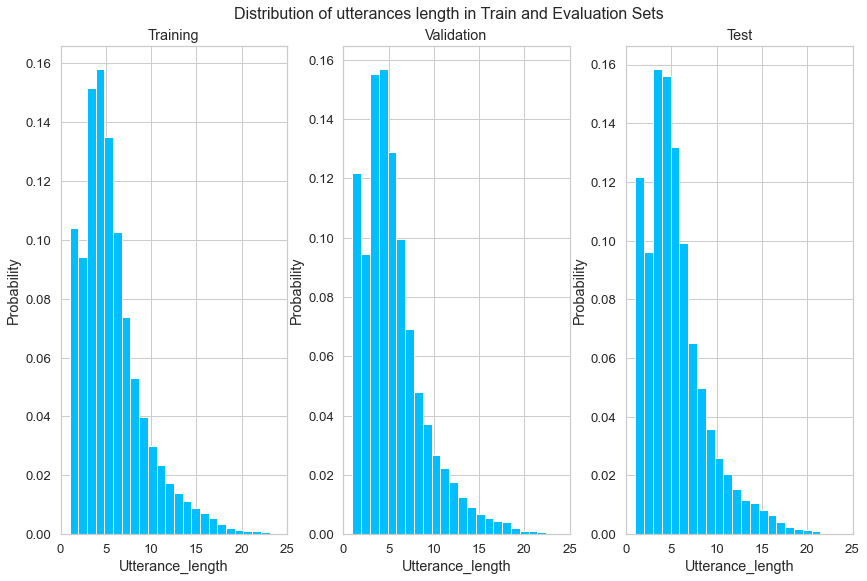

In [57]:
fig, ax =plt.subplots(1,3)
fig.suptitle('Distribution of utterances length in Train and Evaluation Sets', fontsize=16)
fig.tight_layout()
ax[0].set_title('Training')
ax[0].set_xlim([0, 25])
ax[0].set(xlabel='Utterance_length', ylabel='Probability')
ax[0].hist(d['Training'], bins = 150, density = True)

ax[1].set_title('Validation')
ax[1].set_xlim([0, 25])
ax[1].hist(d['Validation'], bins = 73, density = True)
ax[1].set(xlabel='Utterance_length', ylabel='Probability')


ax[2].set_title('Test')
ax[2].set_xlim([0, 25])
ax[2].hist(d['Test'], bins = 115, density = True)
ax[2].set(xlabel='Utterance_length', ylabel='Probability')

# Distribution of utterance length per emotion class in train set
- Utterance length distribution per class is similar peaking around 5 words per utterance. 


In [59]:
d = {"happy":[],"sad":[],"angry":[] };
for col in ['turn1', 'turn2', 'turn3']:
    for label, token in zip(df_train.label, df_train[col]):
        if (label == "others"):
            continue
        d[label].append(len(token.split()))

In [60]:
len(d['happy']), len(d['sad']), len(d['angry'])

(12729, 16389, 16518)

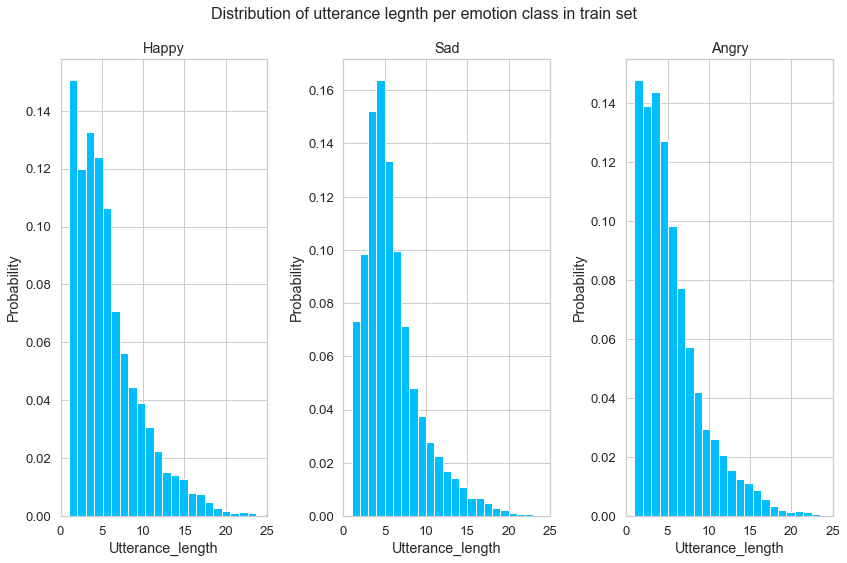

In [67]:
fig, ax =plt.subplots(1,3)
fig.suptitle('Distribution of utterance legnth per emotion class in train set', fontsize=16)
fig.tight_layout()
ax[0].set_title('Happy')
ax[0].set_xlim([0, 25])
ax[0].set(xlabel='Utterance_length', ylabel='Probability')
ax[0].hist(d['happy'], bins = 100, density = True)

ax[1].set_title('Sad')
ax[1].set_xlim([0, 25])
ax[1].hist(d['sad'], bins = 45, density = True)
ax[1].set(xlabel='Utterance_length', ylabel='Probability')
plt.tight_layout()


ax[2].set_title('Angry')
ax[2].set_xlim([0, 25])
ax[2].hist(d['angry'], bins = 45, density = True)
ax[2].set(xlabel='Utterance_length', ylabel='Probability')
plt.tight_layout()

# Comparision of utterance legnth distribution per emotion class

In [27]:
d = {"happy":[],"sad":[],"angry":[] };
for col in ['turn1', 'turn2', 'turn3']:
    for label, token in zip(df_train.label, df_train[col]):
        if (label == "others"):
            continue
        d[label].append(len(token.split()))

<AxesSubplot:title={'center':'Distribution of Utterance length per emotion class'}>

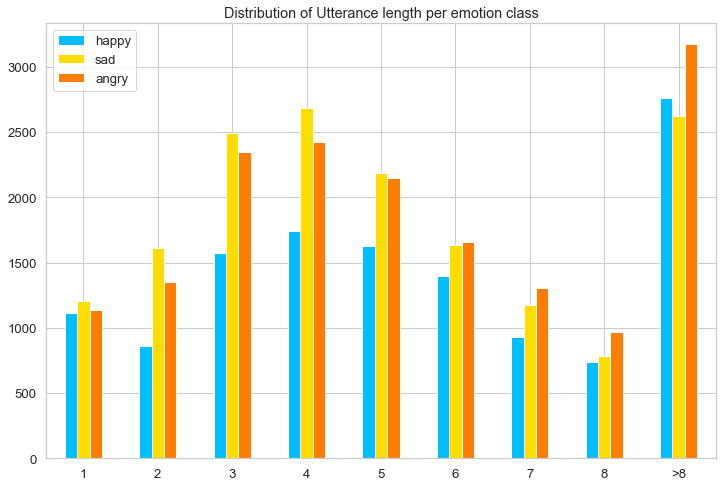

In [28]:
index = [1, 2, 3,
         4, 5, 6, 7, 8, 9]
columns = ["happy", "sad","angry"]
df_wc =  pd.DataFrame(columns = columns, index=index)
df_wc = df_wc.fillna(0)
for keys in d.keys():
    for i in range (len( d[keys])):
        for j in range(1, 10):
            if j == 9:
                if d[keys][i]>=9:
                        df_wc.loc[j, keys] +=1
            else:
                if d[keys][i] == j:
                    df_wc.loc[j, keys] +=1
                        
       
               
df_wc.index = ['1', '2', '3', '4', '5','6', '7', '8', '>8']        
df_wc.plot.bar(rot=0, title = 'Distribution of Utterance length per emotion class')

### We define 2 set of dictionaries
- emodict : Enumerate the emotions present in the dataset
- focus_dict : Enumerate the smaller subset of emotions that we want to focus on

For Semeval Task3, emodict and focus_dict are same. We train the model to learn all 4 emotions persent in the training set. 

In [29]:
if args.emoset == 'emorynlp':
    emo_dict= {'neutral': 0, 'sad': 1, 'mad':2, 'joyful':3, 'peaceful':4,'powerful':5, 'scared':6}
    focus_dict = ['neutral', 'sad', 'mad', 'joyful', 'peaceful', 'powerful', 'scared']
elif args.emoset == 'friends':
    emo_dict = {'neutral': 0, 'sadness': 1, 'anger':2, 'joy':3, 'non-neutral':4,'surprise':5, 'fear':6, 'disgust':7}
    focus_dict = ['neutral', 'sadness', 'anger', 'joy']
elif args.emoset == 'emotionpush':
    emo_dict = {'neutral': 0, 'sadness': 1, 'anger':2, 'joy':3, 'non-neutral':4,'surprise':5, 'fear':6, 'disgust':7}
    focus_dict = ['neutral', 'sadness', 'anger', 'joy']
elif args.emoset == 'semeval':
    emo_dict = {'others': 0, 'sad': 1, 'angry':2, 'happy':3}
    focus_dict = ['sad', 'angry', 'happy']

print('Emotion Mapping {}'.format(emo_dict))
print('Focus Emotion {}'.format(focus_dict))
emo_count = {}
for emo in emo_dict.keys():
        emo_count[emo] =df_train['label'].value_counts()[emo]
print('Emotion Label Distribution in Training Set {}'.format(emo_count))
emo_count = {}
for emo in emo_dict.keys():
        emo_count[emo] =df_val['label'].value_counts()[emo]
print('Emotion Label Distribution in Validation Set {}'.format(emo_count))
emo_count = {}
for emo in emo_dict.keys():
        emo_count[emo] =df_test['label'].value_counts()[emo]
print('Emotion Label Distribution in Test Set {}'.format(emo_count))

Emotion Mapping {'others': 0, 'sad': 1, 'angry': 2, 'happy': 3}
Focus Emotion ['sad', 'angry', 'happy']
Emotion Label Distribution in Training Set {'others': 14948, 'sad': 5463, 'angry': 5506, 'happy': 4243}
Emotion Label Distribution in Validation Set {'others': 2338, 'sad': 125, 'angry': 150, 'happy': 142}
Emotion Label Distribution in Test Set {'others': 4677, 'sad': 250, 'angry': 298, 'happy': 284}


# Data Preprocessing

Machine Learning models don’t work with text and require data preprocessing to convert text to numbers. As we are using BERT for modelling the word level inputs, we need to do following preprocessing

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called attention mask

We will use the pretrained bert model and tokenizers from the Transformers Library 

# DataLoader Class
As the same utterance can deliver different emotions when it is in different contexts, it is imperative to look at the context of previous utterances in the dialogue while modellign the emotion label. On the other hand, utterances between 2 dialogues are independent of each other. We create a class called CustomDataset, and pass the argument Dataset, to allow it to inherit the functionality of the Torch Dataset Class.

In [30]:
class CustomDataset(Dataset):
    def __init__(self, df, max_number_of_speakers_in_dialogue, emo_dict, args):
        self.data = df
     
        self.max_number_of_speakers_in_dialogue = max_number_of_speakers_in_dialogue
        self.emo_dict = emo_dict
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.args = args
        
    def __len__(self):
        if not self.args.emoset == 'semeval':
            return len( self.data['dialogue_id'].unique())
        else:
            return self.data.shape[0]
    
    def get_labels(self, df):
        """
        returns the labels according to the emotion dictionary
        """
        return torch.tensor([self.emo_dict[label] for label in df['label'].values])
    
    '''
        Machine Learning models don’t work with text and require data preprocessing to convert text to numbers. As we are
        using BERT for modelling the word level inputs, we need to do following preprocessing

        - Add special tokens to separate sentences and do classification
        - Pass sequences of constant length (introduce padding)
        - Create array of 0s (pad token) and 1s (real token) called attention mask

        We will use the pretrained bert model and tokenizers from the Transformers Library 
    
    '''
    
    def transform_data(self, df, max_seq_len):
        """
        returns the padded input ids and attention masks according to the DistilBert tokenizer
        """
               
        def tokenize_fct(turn):
            return self.tokenizer.encode(turn, truncation = True, add_special_tokens=True, max_length=max_seq_len)
        
        if not self.args.emoset == 'semeval':
            tokenized = df[['utterance']].applymap(tokenize_fct)
            padded = torch.tensor([[ids + [0]*(max_seq_len-len(ids)) for ids in idx] for idx in tokenized.values])
            attention_mask = torch.where(padded != 0, torch.ones_like(padded), torch.zeros_like(padded))
        else:
            tokenized = df[['turn1','turn2','turn3']].applymap(tokenize_fct)
            padded = torch.tensor([[ids + [0]*(max_seq_len-len(ids)) for ids in idx] for idx in tokenized.values])
            attention_mask = torch.where(padded != 0, torch.ones_like(padded), torch.zeros_like(padded))
        return padded, attention_mask, tokenized

    
    def __getitem__(self, idx):
        
        if not self.args.emoset == 'semeval':
            assert idx  in list(range (len( self.data['dialogue_id'].unique())))
            df = self.data.loc[self.data.dialogue_id ==idx]
        else:
            df = self.data.loc[self.data.index ==idx]
        padded, attention_mask, tokenizer = self.transform_data(df, self.args.max_seq_len)
        labels = self.get_labels(df)
        
        if not self.args.emoset == 'semeval':
            padded = padded.squeeze(dim=1)
            attention_mask = attention_mask.squeeze(dim=1)
        else:
            padded = padded.squeeze(dim=0)
            attention_mask = attention_mask.squeeze(dim=0)
        padded = padded.cuda(self.args.device)
        attention_mask = attention_mask.cuda(self.args.device)
        labels = labels.cuda(self.args.device)
        if self.args.speaker_embedding:
            cat = OneHotEncoder()
            speakers_array = np.array(df.speaker).reshape(-1, 1)
            number_of_speakers_in_dialogue = np.unique(speakers_array).shape[0]
            spkr_emd = cat.fit_transform(speakers_array).toarray()
            spkr_emd = np.pad(spkr_emd, (0, (self.max_number_of_speakers_in_dialogue - number_of_speakers_in_dialogue)))[0:spkr_emd.shape[0], :]
        else:
            spkr_emd = 0
        
        return padded, attention_mask, spkr_emd, labels

## Transformer Sentence Embeddings

We use a pretrained DistilBert model to create sentence embeddings for each utterance. We obtain contextual word embeddings by concatenating the CLS token embedding and the mean of the last layer. 

For more information on the (Distil)Bert models one can look at 
Jay Alammar's blog posts ([A Visual Guide to Using BERT for the First Time](https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/) and [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)) where also the following illustration is taken from.

![DistilBert output](./images/bert-distilbert-output-tensor-predictions.png)

Further references:
 
* [DistilBert paper](https://arxiv.org/abs/1910.01108) and [blog post](https://medium.com/huggingface/distilbert-8cf3380435b5)
* [Original Bert (Bidirectional Encoder Representations from Transformers) paper](https://arxiv.org/abs/1810.04805)
* [tutorial for custom PyTorch modules](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)
* [Huggingface transformers documentation](https://huggingface.co/transformers/v2.3.0/index.html)

In [31]:
class sentence_embeds_model(torch.nn.Module):
    """
    instantiates the pretrained DistilBert model and the linear layer
    """
    
    def __init__(self, args, dropout = 0.1):
        super(sentence_embeds_model, self).__init__()
        
        self.transformer = DistilBertModel.from_pretrained('distilbert-base-uncased', dropout=dropout, 
                                                           output_hidden_states=True)
        
        self.embedding_size = 2 * self.transformer.config.hidden_size
        self.args = args
      
        
    def layerwise_lr(self, lr, decay):
        """
        returns grouped model parameters with layer-wise decaying learning rate
        """
        bert = self.transformer
        num_layers = bert.config.n_layers
        opt_parameters = [{'params': bert.embeddings.parameters(), 'lr': lr*decay**num_layers}]
        opt_parameters += [{'params': bert.transformer.layer[l].parameters(), 'lr': lr*decay**(num_layers-l+1)} 
                            for l in range(num_layers)]
        return opt_parameters
               
    def forward(self, input_ids = None, attention_mask = None, input_embeds = None):
        """
        returns the sentence embeddings
        """
        utterance_count = input_ids.shape[1]
        
        if input_ids is not None:
            input_ids = input_ids.flatten(end_dim = 1)
     
        if attention_mask is not None:
            attention_mask = attention_mask.flatten(end_dim = 1)
        
       
       
        output = self.transformer(input_ids = input_ids, 
                                  attention_mask = attention_mask, inputs_embeds = input_embeds)
      
        cls = output[0][:,0]
        hidden_mean = torch.mean(output[1][-1],1)
        sentence_embeds = torch.cat([cls, hidden_mean], dim = -1)
        sentence_embeds = sentence_embeds.view(-1,utterance_count, self.embedding_size)
       
        return sentence_embeds

## Context Transformer and Classification

We use another transformer model to create contextual sentence embeddings, i.e. we model that a conversation consists of multiple utterances. Moreover, we add a classification model for the emotion of the last utterance where we augment the loss by a binary loss due to the unbalanced data.

Note that for our convenience we use

* a linear projection of the sentence embeddings to a given `projection_size`
* a (not pre-trained) DistilBertForSequenceClassification and flip the order of the utterances as the first input embedding gets classified by default
* only one attention head, see also the paper [Are Sixteen Heads Really Better than One?](https://arxiv.org/abs/1905.10650).

In [32]:
class context_classifier_model(torch.nn.Module):
    """
    instantiates the DisitlBertForSequenceClassification model, the position embeddings of the utterances, 
    and the binary loss function
    """
    
    def __init__(self, 
                 embedding_size, 
                 projection_size, 
                 n_layers, 
                 emo_dict, 
                 focus_dict, 
                 max_number_of_speakers_in_dialogue, 
                 max_number_of_utter_in_dialogue,
                 args,
                 loss_weights,
                 dropout = 0.1):
        super(context_classifier_model, self).__init__()
     
        self.projection_size = projection_size
        self.projection = torch.nn.Linear(embedding_size, projection_size)  
        self.max_number_of_speakers_in_dialogue = max_number_of_speakers_in_dialogue
        self.max_number_of_utter_in_dialogue = max_number_of_utter_in_dialogue
        self.position_embeds = torch.nn.Embedding( self.max_number_of_utter_in_dialogue, projection_size)
     
        self.norm = torch.nn.LayerNorm(projection_size+self.max_number_of_speakers_in_dialogue)
        self.drop = torch.nn.Dropout(dropout)
        self.focus_dict = focus_dict
        self.emo_dict = emo_dict
        self.args = args
        self.loss_weights = loss_weights
        context_config = DistilBertConfig(dropout=dropout, 
                                dim=projection_size+self.max_number_of_speakers_in_dialogue,
                                hidden_dim=4*projection_size,
                                n_layers=n_layers,
                                n_heads = 1,
                                num_labels=len(self.emo_dict.keys()))

        self.context_transformer = DistilBertForSequenceClassification(context_config)
        if not self.args.emoset == 'semeval':
            self.others_label = self.emo_dict['neutral']
        else:
            self.others_label = self.emo_dict['others']
        self.bin_loss_fct = torch.nn.BCEWithLogitsLoss()
   
        
    def bin_loss(self, logits, labels):
        """
        defined the additional binary loss for the `others` label
        """
        bin_labels = torch.where(labels == self.others_label, torch.ones_like(labels), 
                                 torch.zeros_like(labels)).float()
        bin_logits = logits[:, self.others_label]    
        return self.bin_loss_fct(bin_logits, bin_labels)

    
    
    def comput_loss(self, log_prob, target, weights):
        """ Weighted loss function """
        #loss = F.nll_loss(log_prob, target, weight=weights, reduction='sum')
        loss = F.cross_entropy(log_prob, target, weight=weights, reduction='sum')
        loss /= target.size(0)

        return loss


    def forward(self, sentence_embeds, spkr_emd, labels = None):
        """
        returns the logits and the corresponding loss if `labels` are given
        """
        
        position_ids = torch.arange(sentence_embeds.shape[1], dtype=torch.long, device=sentence_embeds.device)
   
        position_ids = position_ids.expand(sentence_embeds.shape[:2]) 
        position_embeds = self.position_embeds(position_ids)
        sentence_embeds = self.projection(sentence_embeds) + position_embeds 
        if self.args.speaker_embedding:
            sentence_embeds = torch.cat((sentence_embeds, spkr_emd), dim=2)
            sentence_embeds = sentence_embeds.to(device=self.args.device, dtype=torch.float)
        sentence_embeds = self.drop(self.norm(sentence_embeds))
    
        if labels is None:
            if not self.emoset == 'semeval':
                return self.context_transformer(inputs_embeds = sentence_embeds.transpose(0, 1), labels = labels)[0]
            else:
                return self.context_transformer(inputs_embeds = sentence_embeds.flip(1), labels = labels)[0]
        else:
            if not self.args.emoset == 'semeval':
                output =  self.context_transformer(inputs_embeds = sentence_embeds.transpose(0, 1), labels = labels)
            else:
                output =  self.context_transformer(inputs_embeds = sentence_embeds.flip(1), labels = labels)
        loss = output[0]
        logits = output[1]
        log_prob = logits
        if not self.args.emoset == 'semeval':
            loss2 = self.comput_loss(log_prob, labels, self.loss_weights)
            return loss2, logits
        else:
            return loss + self.bin_loss(logits, labels), logits
        

# Metrices

- Semeval Task 3 : We use the metrics, i.e. microaveraged precision, recall, and f1-score (while ignoring the others class), for the evaluation of our model according to the [SemEval-2019 Task 3 challenge](https://www.aclweb.org/anthology/S19-2005/). 

- Friends/EmoryPush/EmoryNLP : we choose the macro averaged F1-score as the primary metric for evaluating the performance of our models.

In [33]:
def metrics(loss, logits, labels, emo_dict,focus_emo, args):
    
    labelslist = labels.cpu().tolist()
    preds = torch.argmax(logits, dim=1)
    predslist = preds.cpu().tolist() 
  
    cm = np.zeros((len(emo_dict.keys()),len(emo_dict.keys())), dtype=np.int64) # recall
       
  
    for label, pred in zip(labels.view(-1), preds.view(-1)):
        cm[label.long(), pred.long()] += 1
   
    if not args.emoset == 'semeval':
        cm = cm[0:len(focus_emo), 0:len(focus_emo)]
        gt_labels_per_class =  cm.sum(axis = 1)
        preds_per_class =  cm.sum(axis = 0)
        tp = cm.diagonal()[0:]
        fp = preds_per_class-tp
        fn = gt_labels_per_class- tp
    else:
        gt_labels_per_class =  cm[1:, :].sum(axis = 1)
        preds_per_class =  cm[:, 1:].sum(axis = 0)
        tp = cm.diagonal()[1:]
        fp = preds_per_class-tp
        fn = gt_labels_per_class- tp
   
    return {'val_loss': loss, 
            'tp': tp, 
            'fp': fp, 
            'fn': fn, 
            'preds':preds_per_class,
            'labels': gt_labels_per_class            
            }
def calc_f1_score(tp, fp, fn):
    prec_rec_f1 = {}
    tp_fn = tp+fn
    tp_fp = tp+fp


    Recall = [np.round(tp/tp_fn*100, 2) if tp_fn>0 else 0.0 for tp,tp_fn in zip(tp,tp_fn)]
    prec_rec_f1['microRecall'] = np.round((sum(tp)/ sum(tp_fn))*100, 2)
    prec_rec_f1['macroRecall'] = np.round (sum(Recall) / len(Recall),2)
    
    Precision = [np.round(tp/tp_fp*100, 2) if tp_fp>0 else 0.0 for tp,tp_fp in zip(tp,tp_fp)]
    prec_rec_f1['microPrecision'] = np.round((sum(tp)/ sum(tp_fp))*100, 2)
    prec_rec_f1['macroPrecision'] = np.round(sum(Precision) / len(Precision),2)
    
    f1score = []
    f1_numenator = [2*x*y for (x, y) in zip(Recall, Precision)]
    f1_denominator = [x + y for (x, y) in zip(Recall, Precision)]

    for num1, num2 in zip(f1_numenator,f1_denominator):
        if  num2:
            f1score.append(np.round(num1 / num2, 2))
        else:
            f1score.append(0.0)
 
    prec_rec_f1['microF1_score'] = 2 * (prec_rec_f1['microPrecision'] * prec_rec_f1['microRecall']) / (prec_rec_f1['microPrecision'] + prec_rec_f1['microRecall'])
    prec_rec_f1['macroF1_score'] = np.round(sum(f1score) / len(f1score), 2)
    
    return prec_rec_f1



# PyTorch Lightning

> We use pytorch lighting framework for the Training/Evaluation Loop Implementation

In [39]:
class EmotionModel(pl.LightningModule):
    """
    PyTorch Lightning module for the Contextual Emotion Detection in Text Challenge
    """

    def __init__(self, emo_dict, focus_dict, args, df_train, df_val, df_test):
        """
        pass in parsed HyperOptArgumentParser to the model
        """
        super(EmotionModel, self).__init__()

        self.model_name = 'Semeval'
        self.emo_dict = emo_dict
        self.focus_dict = focus_dict
        self.focus_emo = [emo_dict[w] for w in focus_dict]
        self.max_seq_len = args.max_seq_len
        self.dropout = args.dropout
        self.projection_size = args.projection_size
        self.args = args
        self.n_layers = args.n_layers
        self.df_train = df_train
        self.df_val = df_val
        self.df_test = df_test
        self.loop_count = 0
        if args.speaker_embedding:
            print('Speaker Embedding is Enabled')
            self.max_number_of_speakers_in_dialogue = self.get_max_number_of_speakers_in_dialogue()
            print('Max number of speakers in a dialgue = {}'.format(self.max_number_of_speakers_in_dialogue))
            
        else:
            print('Speaker Embedding is Disabled')
            self.max_number_of_speakers_in_dialogue =0
        if not self.args.emoset == 'semeval':
            self.max_number_of_utter_in_dialogue = self.get_max_utterance_length_in_dialogue()
        else:
            self.max_number_of_utter_in_dialogue = 3
        
        #Need to explore this hyperparameter
        self.weight_rate =1
        self.loss_weights = self.calc_loss_weight(self.df_train, self.weight_rate )
        self.loss_weights = self.loss_weights.cuda(self.args.device)
        print( 'loss weights = {}'.format(self.loss_weights))
        self.class_weights = self.calc_class_weight(self.df_train, self.weight_rate )
        self.class_weights = self.class_weights.cuda(self.args.device)
        print( 'class weights = {}'.format(self.class_weights))
        self.sentence_embeds_model = sentence_embeds_model(self.args, dropout = self.dropout)
        self.context_classifier_model = context_classifier_model(self.sentence_embeds_model.embedding_size,
                                                                 self.projection_size, 
                                                                 self.n_layers, 
                                                                 self.emo_dict, 
                                                                 self.focus_dict,
                                                                 self.max_number_of_speakers_in_dialogue,
                                                                 self.max_number_of_utter_in_dialogue,
                                                                 self.args,
                                                                 self.loss_weights,
                                                                 dropout = self.dropout)
        self.sentence_embeds_model.cuda(self.args.device)
        self.context_classifier_model.cuda(self.args.device)
    
    def calc_loss_weight(self, df, rate=1.0):
        """ Loss weights """
        emo_count = {}
        for emo in self.emo_dict.keys():
            emo_count[emo] =df['label'].value_counts()[emo]
        min_emo = float(min([ emo_count[w] for w in self.focus_dict]))
        weight = [math.pow(min_emo / emo_count[k], rate) if k in self.focus_dict else 0 for k,v in emo_count.items()]
        weight = np.array(weight)
        weight /= np.sum(weight)
        weight = torch.from_numpy(weight).float()
        return weight
    
    def calc_class_weight(self, df, rate=1.0):
        """ class weights """
        emo_count = {}
        for emo in self.emo_dict.keys():
            if emo in self.focus_dict:
                emo_count[emo] =df['label'].value_counts()[emo]
            
        
        weight = [(v / sum(emo_count.values())) for k,v in emo_count.items()]
        weight = np.array(weight)
        weight = torch.from_numpy(weight).float()
        return weight
        
    def get_max_number_of_speakers_in_dialogue(self):
        number_of_speakers_in_dialogue = []
        train_dialogue_id_list = list((self.df_train['dialogue_id'].unique()))
        val_dialogue_id_list = list((self.df_val['dialogue_id'].unique()))
        test_dialogue_id_list = list((self.df_test['dialogue_id'].unique()))
        
        for dialogue in train_dialogue_id_list:
            number_of_speakers_in_dialogue.append(len(set(self.df_train[(self.df_train.dialogue_id ==dialogue)].speaker)))
        for dialogue in val_dialogue_id_list:
            number_of_speakers_in_dialogue.append(len(set(self.df_val[(self.df_val.dialogue_id ==dialogue)].speaker)))
        for dialogue in test_dialogue_id_list:
            number_of_speakers_in_dialogue.append(len(set(self.df_test[(self.df_test.dialogue_id ==dialogue)].speaker)))
        return( max(number_of_speakers_in_dialogue))
    
    def get_max_utterance_length_in_dialogue(self):
        #import IPython; IPython.embed();  exit(1)
        train_dialogue_id_list = list((self.df_train['dialogue_id'].unique()))
        val_dialogue_id_list = list((self.df_val['dialogue_id'].unique()))
        test_dialogue_id_list = list((self.df_test['dialogue_id'].unique()))
        number_of_utterance_in_dialogue = []
        for dialogue in train_dialogue_id_list:
             number_of_utterance_in_dialogue.append((self.df_train.dialogue_id ==dialogue).sum())
        for dialogue in val_dialogue_id_list:
             number_of_utterance_in_dialogue.append((self.df_val.dialogue_id ==dialogue).sum())
        for dialogue in test_dialogue_id_list:
             number_of_utterance_in_dialogue.append((self.df_test.dialogue_id ==dialogue).sum())
        return( max(number_of_utterance_in_dialogue))
       

    def forward(self, input_ids, attention_mask, spkr_emd, labels = None):
        """
        no special modification required for lightning, define as you normally would
        """
      
        sentence_embeds = self.sentence_embeds_model(input_ids = input_ids, 
                                                             attention_mask = attention_mask)
    
        return self.context_classifier_model(sentence_embeds = sentence_embeds,spkr_emd = spkr_emd, labels = labels)
    
    def training_step(self, batch, batch_idx):
        """
        Lightning calls this inside the training loop
        """       
        input_ids, attention_mask, spkr_emd , labels = batch
        spkr_emd = spkr_emd.cuda(self.args.device)
        labels = labels.view(-1)
              
        loss, _ = self.forward(input_ids = input_ids, attention_mask = attention_mask, spkr_emd = spkr_emd, labels = labels)
       
        tensorboard_logs = {'train_loss': loss}
        self.log('train_loss', loss, prog_bar=True)
        return {'loss': loss, 'log': tensorboard_logs}

    
    def validation_step(self, batch, batch_idx):
        """
        Lightning calls this inside the validation loop
        """
        
        input_ids, attention_mask, spkr_emd , labels = batch
        spkr_emd = spkr_emd.cuda(self.args.device)
        labels = labels.view(-1)
        
        loss, logits = self.forward(input_ids = input_ids, attention_mask = attention_mask,spkr_emd = spkr_emd,  labels = labels)
        scores_dict = metrics(loss, logits, labels, self.emo_dict,self.focus_emo, self.args)
        return scores_dict
    
    def validation_epoch_end(self, outputs):
        """
        called at the end of validation to aggregate outputs
        :param outputs: list of individual outputs of each validation step
        :return:
        """
        #import IPython; IPython.embed();  exit(1)
        tqdm_dict = {}
      
        tqdm_dict['preds'] = [0 for w in self.focus_dict]
        tqdm_dict['labels'] = [0 for w in self.focus_dict]
        tqdm_dict['tp'] = [0 for w in self.focus_dict]
        tqdm_dict['fp'] = [0 for w in self.focus_dict]
        tqdm_dict['fn'] = [0 for w in self.focus_dict]
        tqdm_dict['acc_per_class'] = [0 for w in self.focus_dict]
       
        for metric_name in outputs[0].keys():
            
            if metric_name not in  ['tp', 'fp', 'fn', 'acc_per_class','preds', 'labels']:
                metric_total = 0
            else:
                 metric_total = [0 for w in self.focus_dict]
            
            for output in outputs:
                metric_value = output[metric_name]
                metric_total += metric_value
            if metric_name in ['tp', 'fp', 'fn', 'acc_per_class', 'preds', 'labels']:
                tqdm_dict[metric_name] = metric_total
            else:
                tqdm_dict[metric_name] = metric_total / len(outputs)
        
        for i in range(len(self.focus_dict)):
            if  tqdm_dict['labels'][i]:
                tqdm_dict['acc_per_class'][i] = np.round((tqdm_dict['tp'][i] / tqdm_dict['labels'][i])*100, 2)
            else:
                tqdm_dict['acc_per_class'][i] = 0.0
        
        
        tqdm_dict['acc_unweighted'] = np.round(sum(tqdm_dict['acc_per_class']) / len(tqdm_dict['acc_per_class']),2)       
        tqdm_dict['acc_weighted'] = sum(weight * value for weight, value in zip(self.class_weights, tqdm_dict['acc_per_class']))
        
        tqdm_dict['acc_weighted'] = (tqdm_dict['acc_weighted'] * 10**2).round() / (10**2)
        prec_rec_f1 = calc_f1_score(tqdm_dict['tp'], tqdm_dict['fp'], tqdm_dict['fn'])
        tqdm_dict.update(prec_rec_f1) 
      
        self.log('valid_loss', tqdm_dict["val_loss"], prog_bar=False)
        self.log('valid_ac_unweighted', tqdm_dict["acc_unweighted"], prog_bar=False)
        self.log('microRecall', tqdm_dict["microRecall"], prog_bar=False)
        #print('\nError Metric {}'.format(tqdm_dict))
        print(*tqdm_dict.items(), sep='\n')
        result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': tqdm_dict["val_loss"]}
        
        return result

    
    def test_step(self, batch, batch_idx):
 
        return self.validation_step(batch, batch_idx)

    
    def test_epoch_end(self, outputs):
        return self.validation_epoch_end(outputs)
    
    def configure_optimizers(self):
        """
        returns the optimizer and scheduler
        """
        params = self.sentence_embeds_model.layerwise_lr(self.args.lr, self.args.layerwise_decay)
        params += [{'params': self.context_classifier_model.parameters()}]
        self.optimizer = torch.optim.Adam(params, lr=self.args.lr)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=10)
        return [self.optimizer], [self.scheduler]
    

   
    def train_dataloader(self):
        
        dataset = CustomDataset(self.df_train, self.max_number_of_speakers_in_dialogue, self.emo_dict, self.args)
        train_loader = DataLoader(dataset, self.args.batch_size, shuffle=True, num_workers=0)
      
        return train_loader

    

    def val_dataloader(self):

        dataset = CustomDataset(self.df_val, self.max_number_of_speakers_in_dialogue, self.emo_dict, self.args)
        val_loader = DataLoader(dataset, self.args.batch_size, shuffle=False, num_workers=0)
      
        return val_loader

    def test_dataloader(self):
        
        dataset = CustomDataset(self.df_test, self.max_number_of_speakers_in_dialogue, self.emo_dict, self.args)
        test_loader = DataLoader(dataset, self.args.batch_size, shuffle=False, num_workers=0)
       
        return test_loader

In [40]:
model = EmotionModel(emo_dict, focus_dict, args, df_train, df_val, df_test)
model.cuda(args.device)

Speaker Embedding is Disabled
loss weights = tensor([0.0000, 0.3049, 0.3025, 0.3926], device='cuda:0')
class weights = tensor([0.3591, 0.3620, 0.2789], device='cuda:0')


EmotionModel(
  (sentence_embeds_model): sentence_embeds_model(
    (transformer): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn):

In [41]:
early_stop_callback = pl.callbacks.EarlyStopping(monitor='valid_loss', min_delta=0.00005, patience=3,
                                        verbose=True, mode='min')

checkpoint_callback = pl.callbacks.ModelCheckpoint( monitor='valid_loss' , mode = 'min')

#import IPython; IPython.embed();  exit(1)
gpu_list = [int(args.gpu)]  
trainer = pl.Trainer(default_root_dir=os.getcwd(),
                gpus=(gpu_list if torch.cuda.is_available() else 0),
                max_epochs= args.epochs,
                fast_dev_run=False,
                deterministic=True,
                callbacks = [early_stop_callback,checkpoint_callback] ,
                )
trainer.fit(model)
    

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type                     | Params
----------------------------------------------------------------------
0 | sentence_embeds_model    | sentence_embeds_model    | 66.4 M
1 | context_classifier_model | context_classifier_model | 3.4 M 
----------------------------------------------------------------------
69.8 M    Trainable params
0         Non-trainable params
69.8 M    Total params
279.010   Total estimated model params size (MB)


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Global seed set to 42


('preds', array([64,  0,  0], dtype=int64))
('labels', array([3, 3, 3], dtype=int64))
('tp', array([3, 0, 0], dtype=int64))
('fp', array([61,  0,  0], dtype=int64))
('fn', array([0, 3, 3], dtype=int64))
('acc_per_class', [100.0, 0.0, 0.0])
('val_loss', tensor(2.0911, device='cuda:0'))
('acc_unweighted', 33.33)
('acc_weighted', tensor(35.9100, device='cuda:0'))
('microRecall', 33.33)
('macroRecall', 33.33)
('microPrecision', 4.69)
('macroPrecision', 1.56)
('microF1_score', 8.222919516044188)
('macroF1_score', 2.99)


C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Metric valid_loss improved. New best score: 0.672


('preds', array([164, 186, 185], dtype=int64))
('labels', array([125, 150, 142], dtype=int64))
('tp', array([101, 119, 101], dtype=int64))
('fp', array([63, 67, 84], dtype=int64))
('fn', array([24, 31, 41], dtype=int64))
('acc_per_class', [80.8, 79.33, 71.13])
('val_loss', tensor(0.6722, device='cuda:0'))
('acc_unweighted', 77.09)
('acc_weighted', tensor(77.5700, device='cuda:0'))
('microRecall', 76.98)
('macroRecall', 77.09)
('microPrecision', 60.0)
('macroPrecision', 60.05)
('microF1_score', 67.43758212877792)
('macroF1_score', 67.5)


Metric valid_loss improved by 0.112 >= min_delta = 5e-05. New best score: 0.561


('preds', array([140, 213, 183], dtype=int64))
('labels', array([125, 150, 142], dtype=int64))
('tp', array([100, 126, 106], dtype=int64))
('fp', array([40, 87, 77], dtype=int64))
('fn', array([25, 24, 36], dtype=int64))
('acc_per_class', [80.0, 84.0, 74.65])
('val_loss', tensor(0.5606, device='cuda:0'))
('acc_unweighted', 79.55)
('acc_weighted', tensor(79.9600, device='cuda:0'))
('microRecall', 79.62)
('macroRecall', 79.55)
('microPrecision', 61.94)
('macroPrecision', 62.83)
('microF1_score', 69.67593670528397)
('macroF1_score', 70.04)



In [42]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\neera\anaconda3\envs\NLP3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


('preds', array([309, 388, 362], dtype=int64))
('labels', array([250, 298, 284], dtype=int64))
('tp', array([213, 254, 218], dtype=int64))
('fp', array([ 96, 134, 144], dtype=int64))
('fn', array([37, 44, 66], dtype=int64))
('acc_per_class', [85.2, 85.23, 76.76])
('val_loss', tensor(0.5217, device='cuda:0'))
('acc_unweighted', 82.4)
('acc_weighted', tensor(82.8600, device='cuda:0'))
('microRecall', 82.33)
('macroRecall', 82.4)
('microPrecision', 64.68)
('macroPrecision', 64.87)
('microF1_score', 72.44547173661657)
('macroF1_score', 72.58)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'microRecall': 82.33,
 'valid_ac_unweighted': 82.4,
 'valid_loss': 0.5217400193214417}
--------------------------------------------------------------------------------


[{'valid_loss': 0.5217400193214417,
  'valid_ac_unweighted': 82.4,
  'microRecall': 82.33}]